# Logbook Blocking 

An implementation of the network-based blocking mechanism

In [6]:
%matplotlib inline
import os 
import sys
import random
import networkx as nx 

## Paths from the file 
PROJECT  = os.path.join(os.getcwd(), "..")
FIXTURES = os.path.join(PROJECT, "fixtures")
DATASET  = os.path.join(FIXTURES, 'activity.csv')

## Append the path for the logbook utilities 
sys.path.append(PROJECT)

from logbook.reader import LogReader 
from logbook.graph import *
from logbook.compare import * 

In [2]:
# Actions to exclude from our graph. 
# exclude = None
exclude=['Subscribed to DDL blog', 'Signed up for new course notifications']

# Load dataset and generate graph
dataset = LogReader(DATASET, exclude=exclude)
G = graph_from_triples(dataset)

print info(G)

Name: Logbook Activity
Type: Graph
Number of nodes: 548
Number of edges: 623
Average degree:   2.2737
Number of Actions: 7
Number of Pairwise Comparisons: 149878
Number of Edge Blocked Comparisons: 136377

Action Counts
-------------
Registered for workshop: 352
Applied to DDL incubator: 198
Applied to DDL research lab: 25
Taught workshop: 16
Organized workshop: 12
Wrote blog post: 12
TA for workshop: 8


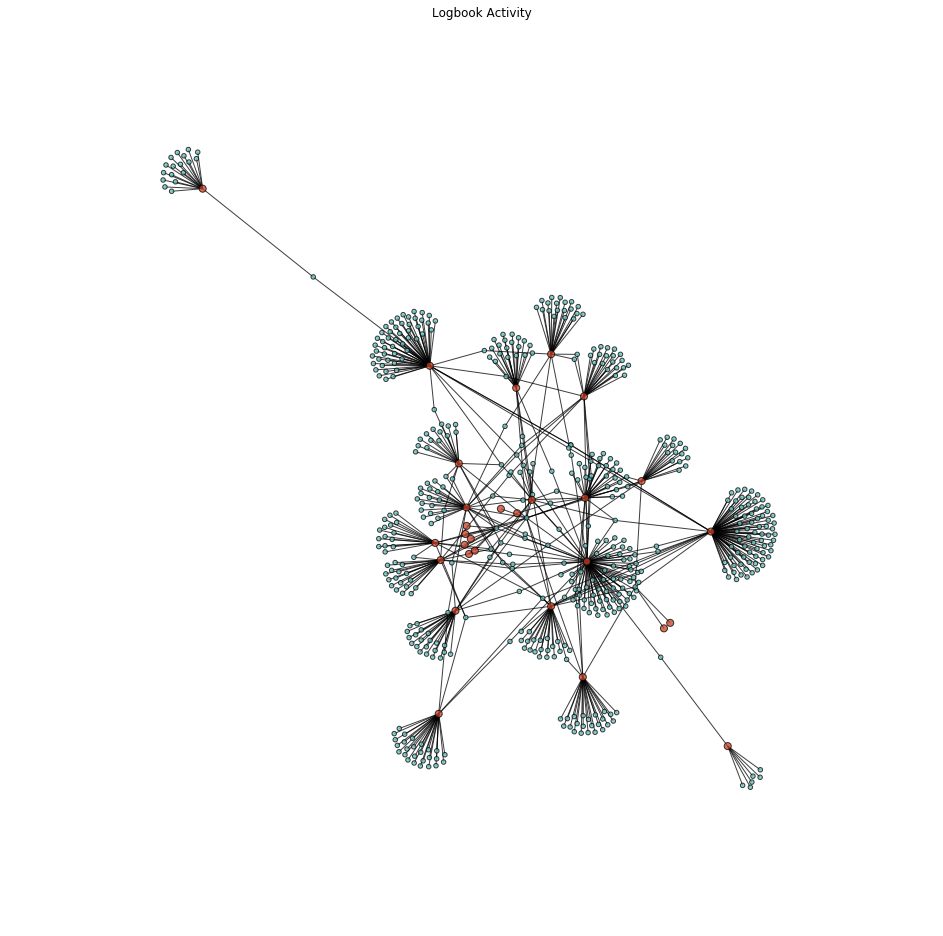

In [3]:
draw_activity_graph(G, connected=True)

## Graph Structured Pairwise Comparisons 

By implementing a graph where person entity nodes are a tuple of `(name, email)` pairs (an immutable data structure that is hashable), we get structure right off the bat by direct comparison. 

The number of pariwise comparisons is computed as: 

$$c = \frac{n(n-1)}{2}$$

Where `n` is the number of nodes in the graph. The graph can be further filtered on entity type as well. Here are a random sample of 5 pairwise node to node comparisons: 

In [4]:
print "Pairwise Comparisons: {}\n\n".format(pairwise_comparisons(G, True))

combos = list(pairwise_comparisons(G, entity='person'))
random.shuffle(combos)
for idx, pair in enumerate(combos):
    print "Pair {}:".format(idx + 1)
    print "    {}\n      -- vs --\n    {}".format(*pair)
    if idx >= 4: break

Pairwise Comparisons: 149878


Pair 1:
    Entity(name=u'Konstantinos Xirogiannopoulos', email=u'kostasxirog91@gmail.com')
      -- vs --
    Entity(name=u'Keegan Hines', email=u'khines@data-tactics.com')
Pair 2:
    Entity(name=u'Rich Heimann', email=u'heimann.richard@gmail.com')
      -- vs --
    Entity(name=u'charles nguyen', email=u'charles.nguyen@mavs.uta.edu')
Pair 3:
    Entity(name=u'Ryan Stephany', email=u'ryan.stephany@gmail.com')
      -- vs --
    Entity(name=u'Hari Sirigibathina', email=u'HARISIRIGIBATHI@GWU.EDU')
Pair 4:
    Entity(name=u'Matt Hoffman', email=u'matt.d.hoffman@gmail.com')
      -- vs --
    Entity(name=u'Nabil Sandhu', email=u'nabil@xululabs.com')
Pair 5:
    Entity(name=u'Elizabeth Cartier', email=u'elizabeth.a.cartier@us.pwc.com')
      -- vs --
    Entity(name=u'Shay Anderson', email=u'shay.m.anderson@us.pwc.com')


Edge structured comparisons only yield nodes so long as the itersection of the node's neighborhoods is empty (that is, two entities can't have an action to the same detail). 

In [5]:
print "Edge Blocked Pairwise Comparisons: {}\n\n".format(edge_blocked_comparisons(G, True))

combos = list(edge_blocked_comparisons(G, entity='person'))
random.shuffle(combos)
for idx, pair in enumerate(combos):
    print "Pair {}:".format(idx + 1)
    print "    {}\n      -- vs --\n    {}".format(*pair)
    
    print "      Connections: "

    neighbors = set(G.neighbors(pair[0])) - set(G.neighbors(pair[1]))
    for n in neighbors:
        print "        {}".format(n)
    if idx >= 4: break

Edge Blocked Pairwise Comparisons: 136377


Pair 1:
    Entity(name=u'Mengxi Lu', email=u'lumengxi@gmail.com')
      -- vs --
    Entity(name=u'Aleksandar Jelenak', email=u'aleksandar.jelenak@gmail.com')
      Connections: 
        Detail(detail=u'Natural Language Processing Basics with NLTK')
Pair 2:
    Entity(name=u'Tej Luthra', email=u'tluthra@att.net')
      -- vs --
    Entity(name=u'Jay Emerson', email=u'jayemerson@gmail.com')
      Connections: 
        Detail(detail=u'Building Data Apps with Python')
Pair 3:
    Entity(name=u'Satya Srinivas Kumar Chilukuri', email=u'satya.chi@gmail.com')
      -- vs --
    Entity(name=u'Travis Pinney', email=u'travis.pinney@gmail.com')
      Connections: 
        Detail(detail=u'Analyzing Social Media Data with R')
Pair 4:
    Entity(name=u'Sumeet Vij', email=u'sumeetvij@hotmail.com')
      -- vs --
    Entity(name=u'Mehdi El Amine', email=u'alamine@gmail.com')
      Connections: 
        Detail(detail=u'Natural Language Processing Basics with

Other structural blocking can then be applied. 

## Fuzziness 

With some blocking in the data structure, we can now begin to do pairwise comparisons. Here, I'll use the `fuzzywuzzy` tool to produce comparisons for the annotator such that the mean of the fuzzy score for both email and name meets a certain threshold. 

In [9]:
combos = list(edge_blocked_comparisons(G, entity='person'))
combos = filter(lambda pair: fuzzblock(*pair), combos)

print "Fuzz/Edge Blocked Pairwise Comparisons: {}\n\n".format(len(combos))

random.shuffle(combos)
for idx, pair in enumerate(combos):
    print "Pair {}:".format(idx + 1)
    print "    {}\n      -- vs --\n    {}".format(*pair)
    
    print "      Connections: "

    neighbors = set(G.neighbors(pair[0])) - set(G.neighbors(pair[1]))
    for n in neighbors:
        print "        {}".format(n)
    if idx >= 4: break

Fuzz/Edge Blocked Pairwise Comparisons: 199


Pair 1:
    Entity(name=u'Nicholas Giangreco', email=u'nick.giangreco@gmail.com')
      -- vs --
    Entity(name=u'Nicolas Durland', email=u'nick.durland@gmail.com')
      Connections: 
        Detail(detail=u'Incubator 2 - Rejected')
Pair 2:
    Entity(name=u'David Cass', email=u'david@cassinc.com')
      -- vs --
    Entity(name=u'Ava Cas', email=u'agdcas@gmail.com')
      Connections: 
        Detail(detail=u'Incubator 1')
Pair 3:
    Entity(name=u'Kenneth Durril', email=u'kdurril@gmail.com')
      -- vs --
    Entity(name=u'Peter Burrell', email=u'peterburrell@gmail.com')
      Connections: 
        Detail(detail=u'Incubator 2 - Accepted')
Pair 4:
    Entity(name=u'Matthew Haggerty', email=u'matt.m.haggerty@gmail.com')
      -- vs --
    Entity(name=u'Matthew Fifer', email=u'msfifer@gmail.com')
      Connections: 
        Detail(detail=u'Data Acquisition & Wrangling with Python')
Pair 5:
    Entity(name=u'craig Yen', email=u'c.timur@yah